# Caso de aplicación

## Portafolio óptimo

### Librerías

In [237]:
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from matplotlib import cm
import scipy.optimize as opt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.optimize import minimize
from joblib import Parallel, delayed 
import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize
from IPython.display import display, Markdown

### Obtención de datos

In [238]:
random.seed(42)
tickers=['WMT','AAPL','GOOGL','PG','JNJ','KO','MCD','SBUX']
tickers2 = ['VTI','VOO']

f_inicial='2020-01-01'
f_final='2024-11-24'

datos1=yf.download(tickers,f_inicial,f_final)['Adj Close']
datos2 = yf.download(tickers2,f_inicial,f_final)['Adj Close']

rt = datos1.pct_change().dropna()
rt2 = datos2.pct_change().dropna()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  2 of 2 completed


### Cálculo de variables

In [239]:
mu = (rt.mean() * 252).values  # Rendimientos esperados
sigma = rt.cov().values  # Matriz de covarianza
sigma_inv = np.linalg.inv(sigma)  # Matriz de covarianza inversa
rf = 0.04413  # Tasa libre de riesgo
unos = np.ones(len(mu)) # Vector de unos
mu_rf = mu - np.dot(rf,unos) # Rendimientos esperados en exceso
n_assets = len(mu)

### Obtención de $w$

In [240]:
w = np.dot(sigma_inv,mu_rf)/ np.dot(unos.T,np.dot(sigma_inv,mu_rf))

### Cálculo del retorno, volatilidad y Sharpe Ratio del portafolio

- $\mu_p = w^{^T}\mu$
- $\sigma_p = \sqrt{ w^{T} \Sigma w}$
- $sr = \frac{\mu_p - r_f}{\sigma_p}$

In [241]:
ret = np.dot(w.T, mu) # Rendimiento esperado del portafolio
risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252) # Volatilidad del portafolio
sharpe = (ret - rf) / risk # Sharpe ratio

### Resultados

In [242]:
w_df = pd.DataFrame(w, index=rt.columns, columns=['w'])

print(f'Rendimiento esperado: {ret:.6%}')
print(f'Volatilidad: {risk:.6%}')
print(f'Ratio de sharpe: {sharpe:.6f}')

display(Markdown('### Valores del vector $w$:'))
display(w_df.T)

Rendimiento esperado: 43.358738%
Volatilidad: 37.382771%
Ratio de sharpe: 1.041810


### Valores del vector $w$:

Ticker,AAPL,GOOGL,JNJ,KO,MCD,PG,SBUX,WMT
w,0.753565,0.213842,-0.77384,-0.427833,0.342418,0.186432,-0.353559,1.058975


## Optimización de portafolios con scipy

In [243]:
# Función para minimizar (-Sharpe Ratio)
def neg_sharpe_ratio(w, mu, sigma, rf):
    port_return = np.dot(w, mu)  # Rendimiento esperado del portafolio
    port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe_ratio = (port_return - rf) / port_vol
    return -sharpe_ratio  # Negativo porque queremos maximizar

# Restricciones: Suma de pesos = 1
constraints = ({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
})

# Límites: Pesos entre 0 y 1 (no posiciones cortas)
bounds = tuple((0, 1) for _ in range(n_assets))

# Pesos iniciales (distribuidos uniformemente)
w0 = np.array([1 / n_assets] * n_assets)

# Optimización
result = opt.minimize(neg_sharpe_ratio, w0, args=(mu, sigma, rf), method='SLSQP', bounds=bounds, constraints=constraints)

# Resultados
optimal_weights = result.x
optimal_sharpe = -result.fun
optimal_weights[optimal_weights < 0.000001] = 0

In [244]:
w_opt_df = pd.DataFrame(optimal_weights, index=rt.columns, columns=['w'])
w_opt_df.T

Ticker,AAPL,GOOGL,JNJ,KO,MCD,PG,SBUX,WMT
w,0.379364,0.074042,0.0,0.0,0.0,0.0,0.0,0.546594


### Backtest de Portafolio óptimo vs S&P 500

In [245]:
portfolio_returns = np.dot(rt, w)
cumulative_return_port = (1 + portfolio_returns).cumprod()

portfolio_returns_opt = np.dot(rt, optimal_weights)
cumulative_return_port_opt = (1 + portfolio_returns_opt).cumprod()

cumulative_return_sp = (1 + rt2['VOO']).cumprod()

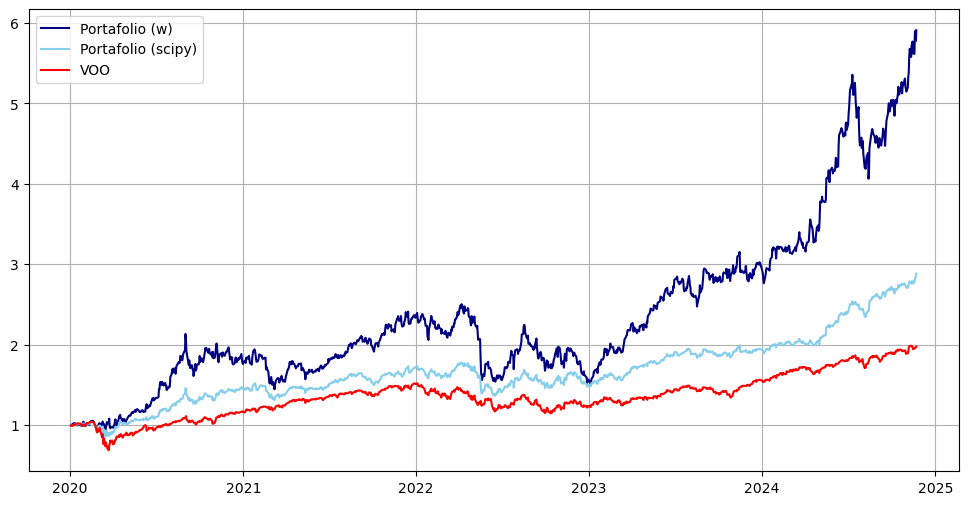

In [246]:
returns = pd.DataFrame({
    'portafolio': cumulative_return_port,
    'portfolio_opt': cumulative_return_port_opt,
    'VOO': cumulative_return_sp
})

plt.figure(figsize=(12, 6))

plt.plot(returns['portafolio'], label='Portafolio (w)', c = 'navy')
plt.plot(returns['portfolio_opt'], label='Portafolio (scipy)', c = 'skyblue')
plt.plot(returns['VOO'], label='VOO', c = 'red')

plt.legend()
plt.grid()

### Simulación de portafolios

In [247]:
# Para las simulaciones
sigma = rt.cov()
n_port = 10000
n_act = len(rt.keys())

W = np.random.dirichlet((1,) * n_act, size=n_port)

# Obten los rendimientos
rendimientos = W.dot(rt.mean()) * 252

# Calcula las volatilidades
zeros = np.zeros(n_port)
for i in range(len(zeros)):
    zeros[i] = np.sqrt(W[i,:].dot(sigma).dot(W[i,:])) * np.sqrt(252)
volatility = zeros

# Sharpe
sharpe = (rendimientos - rf) / volatility

# Data frame de resultados
resultados = pd.DataFrame({
    'rend': rendimientos,
    'vol': volatility,
    'sharpe': sharpe
})
pesos = pd.DataFrame(W, columns=rt.keys())
resultados = pd.concat([resultados, pesos], axis=1)

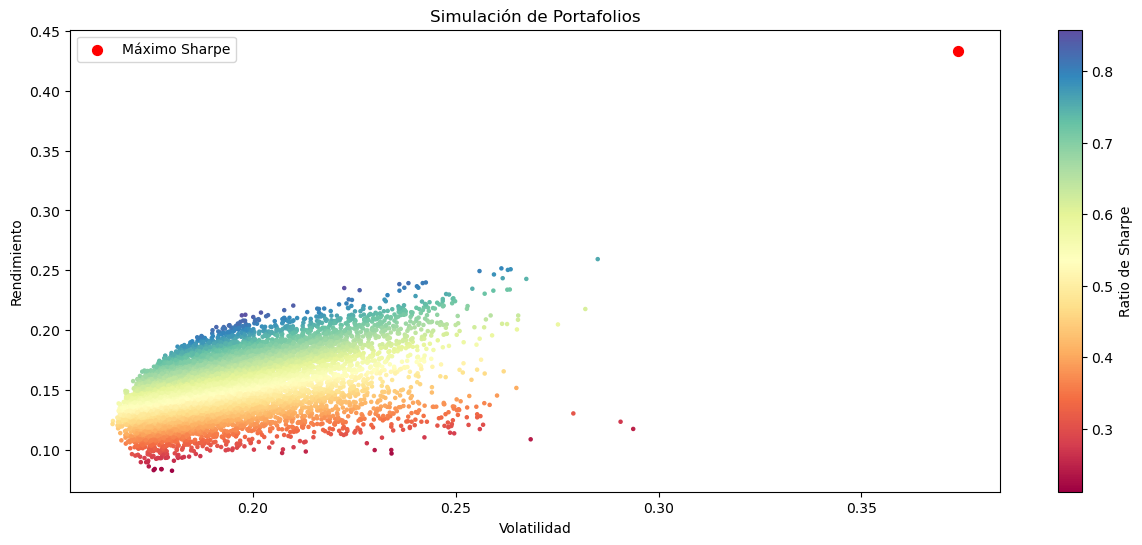

In [248]:
# Crear el gráfico con matplotlib
fig, ax = plt.subplots(figsize=(15, 6))

# Crear la normalización y el mapa de colores
norm = Normalize(vmin=min(sharpe), vmax=max(sharpe))
cmap = matplotlib.colormaps['Spectral']

# Crear el scatter plot
sc = ax.scatter(resultados['vol'], resultados['rend'], c=sharpe, cmap=cmap, norm=norm, s=5)
plt.scatter(risk, ret, color='red', s=50, label='Máximo Sharpe')

# Añadir la barra de colores
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Ratio de Sharpe')

# Añadir etiquetas
ax.set_title('Simulación de Portafolios')
ax.set_xlabel('Volatilidad')
ax.set_ylabel('Rendimiento')

# Mostrar el gráfico
plt.legend()
plt.show()

## Comparación pesos óptimos vs pesos aleatorios

### Funciones

In [249]:
tickers = ['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'SPOT', 'SBUX', 'JPM', 'AXP', 'MCD', 'KO', 
           'NFLX', 'CMG', 'CP', 'WMT', 'V', 'GLD', 'BLK', 'PG', 'JNJ', 'TMUS', 'MA', 'BX', 'LULU', 'DPZ', 'BAC', 
           'FDX', 'DIS', 'GE', 'HSY', 'HP', 'COST', 'HD', 'K', 'ADBE', 'CSCO', 'T', 'F', 'NKE', 'CVX', 'XOM', 'PYPL', 
           'PEP', 'PFE', 'MRNA', 'RL', 'AZN', 'BABA', 'VZ', 'WBD', 'HSBC', 'UBER']

def simulate_portfolio_opt(i, tickers, rf):
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.dot(sigma_inv, mu_rf) / np.dot(unos.T, np.dot(sigma_inv, mu_rf))

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 100  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_opt)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos_opt = [result[0] for result in results]
volatilidades_opt = [result[1] for result in results]
sharpe_ratios_opt = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  8 of 8 completedd
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  6 of 6 completeded
[*************

In [250]:
def simulate_portfolio(i, tickers, rf):
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.random.dirichlet(np.ones(len(mu)), size=1)[0]

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 100  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos = [result[0] for result in results]
volatilidades = [result[1] for result in results]
sharpe_ratios = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  6 of 6 completedd
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  8 of 8 completeddd
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  6 of 6 completeded
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  6 of 6 completedd
[*************

In [251]:
def simulate_portfolio_short(i, tickers, rf):
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.random.uniform(-3, 3, len(mu))
    w /= np.sum(w)

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 100  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_short)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos_short = [result[0] for result in results]
volatilidades_short = [result[1] for result in results]
sharpe_ratios_short = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[******                13%                       ]  2 of 15 completed
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  9 of 9 completeddd
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  6 of 6 completedd
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completedd
[*********************100%***********************]  5 of 5 completeddd
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed
[*************

### DataFrames

In [252]:
metricas_optimas_df = pd.DataFrame({
    'rendimiento': retornos_opt,
    'volatilidad': volatilidades_opt,
    'sharpe': sharpe_ratios_opt
})

In [253]:
metricas_df = pd.DataFrame({
    'rendimiento': retornos,
    'volatilidad': volatilidades,
    'sharpe': sharpe_ratios
})

In [254]:
metricas_df_short = pd.DataFrame({
    'rendimiento': retornos_short,
    'volatilidad': volatilidades_short,
    'sharpe': sharpe_ratios_short
})

### Histogrmas de ratio de Sharpe

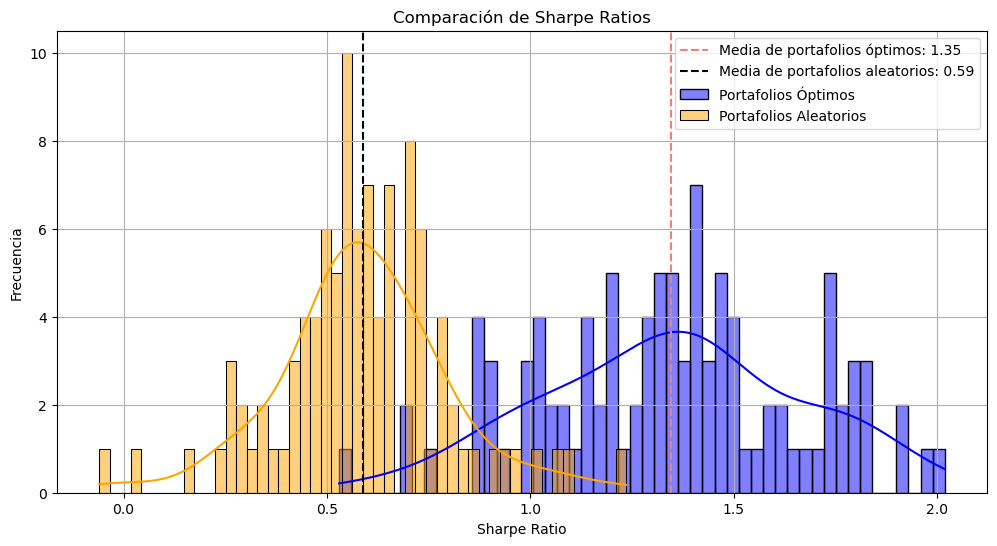

In [255]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df['sharpe'].mean()
random_mean = metricas_df['sharpe'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(random_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {random_mean:.2f}')

plt.legend()
plt.title('Comparación de Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

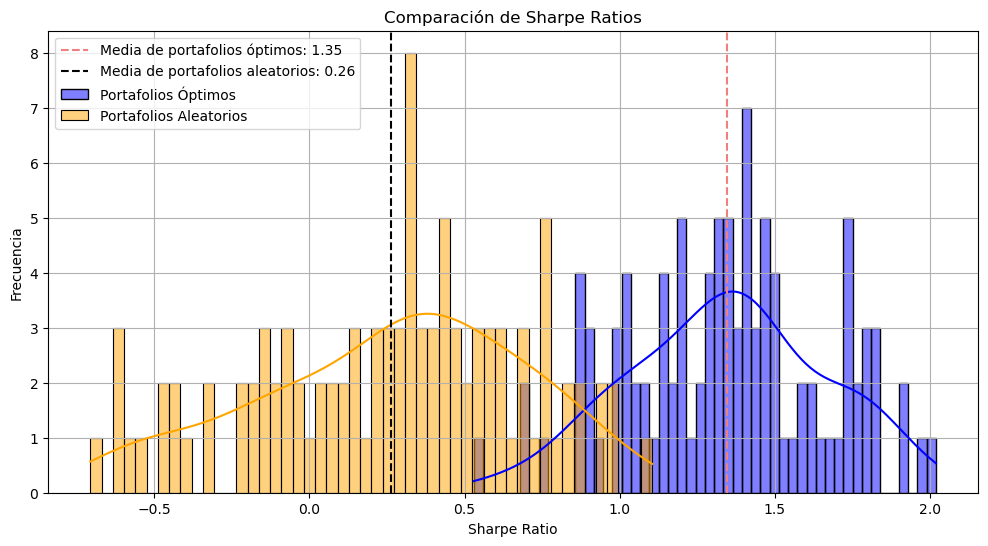

In [256]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df['sharpe'].mean()
short_mean = metricas_df_short['sharpe'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Comparación de Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

### Histograma de rendimientos

In [257]:
metricas_optimas_df_filter = metricas_optimas_df.query('rendimiento > -0.5 and rendimiento < 2 and volatilidad < 1.5')
metricas_df_filter = metricas_df.query('rendimiento > -0.5 and rendimiento < 2')
metricas_df_short_filter = metricas_df_short.query('rendimiento > -0.5 and rendimiento < 2 and volatilidad < 1.5')

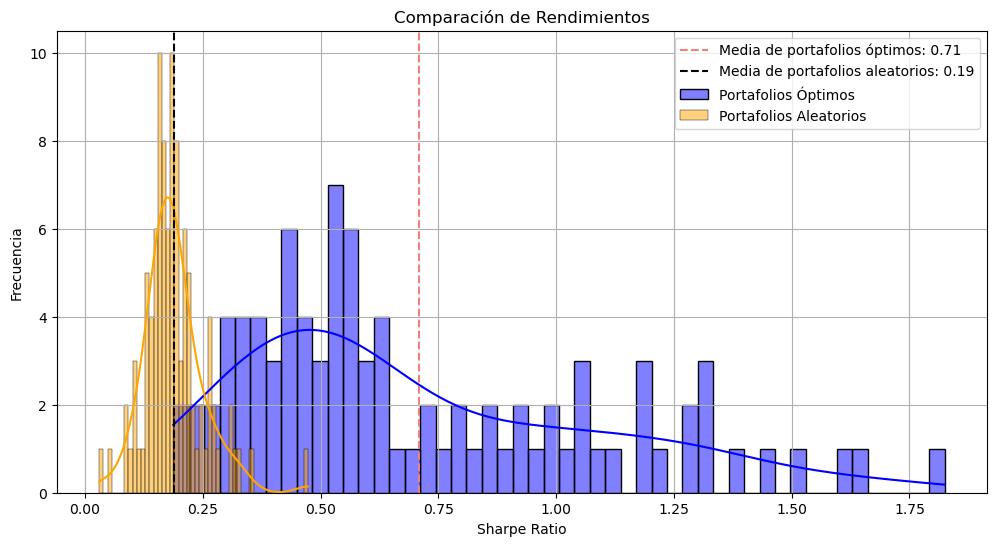

In [258]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['rendimiento'].mean()
short_mean = metricas_df_filter['rendimiento'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Comparación de Rendimientos')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

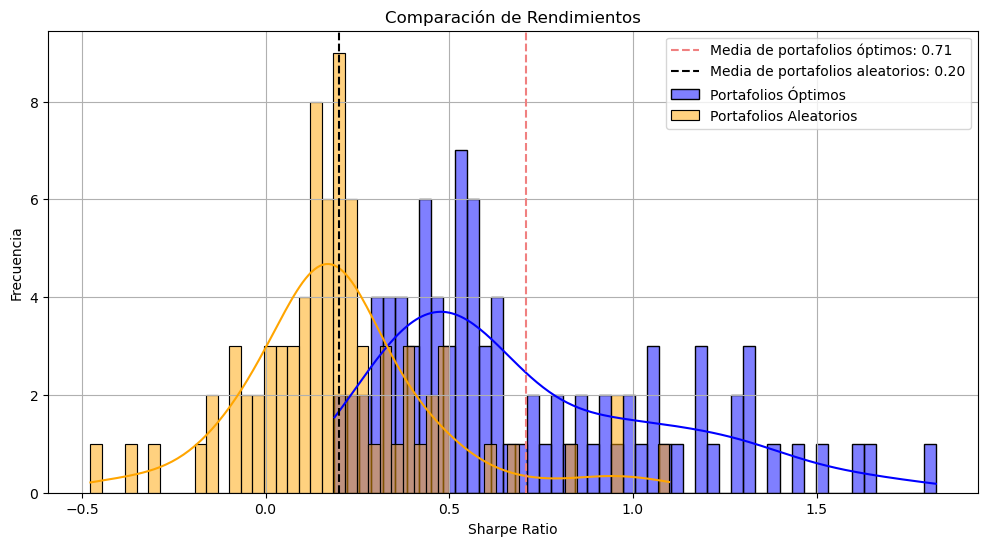

In [259]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['rendimiento'].mean()
short_mean = metricas_df_short_filter['rendimiento'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Comparación de Rendimientos')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

### Compración de volatilidades

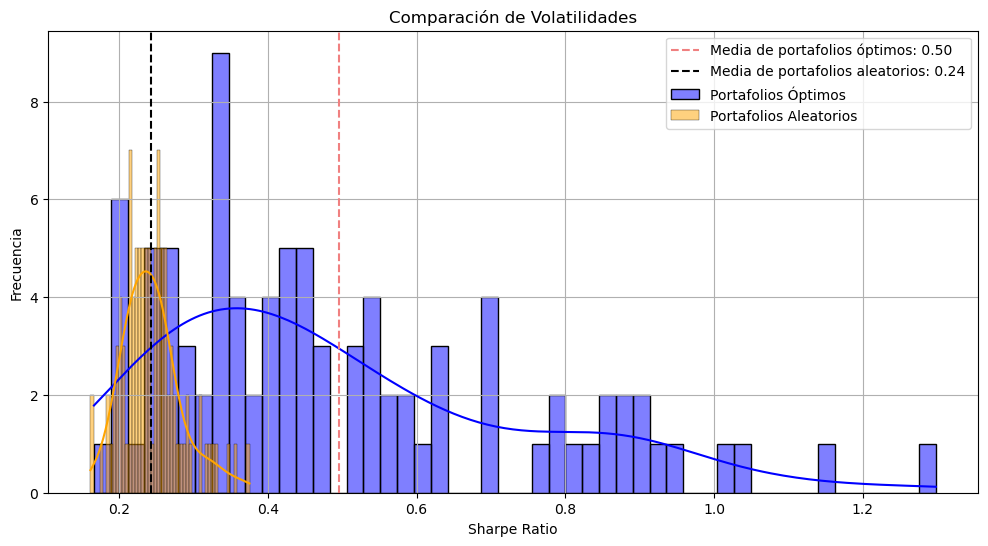

In [260]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['volatilidad'].mean()
short_mean = metricas_df_filter['volatilidad'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Comparación de Volatilidades')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

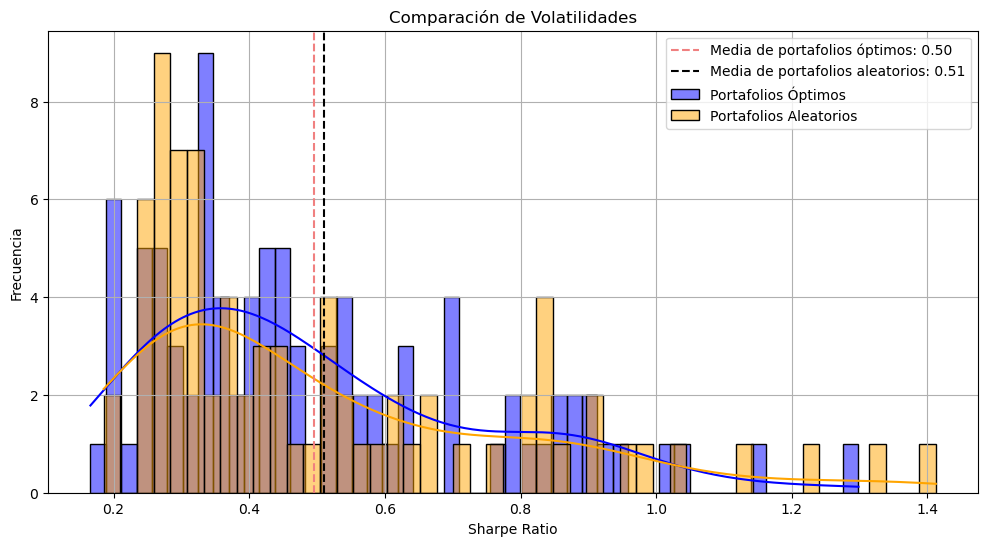

In [261]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['volatilidad'].mean()
short_mean = metricas_df_short_filter['volatilidad'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Comparación de Volatilidades')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()